# Answering Business Questions with SQL

In this project, we are working for an online record store that has tasked us with finding answers to some business questions:

1. What are the top genres of tracks sold in the USA?
2. What is the number of total sales by employee?

Throughout this project, we'l make use of SQL to answer these questions by querying the store's database.

### Setting Up SQL Functions

In order to run our queries on the store's data, we need to first connect to their database. We'll also define some functions to streamline running our queries using the sqlite3 package.

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# function to run SQL queries
def run_query(q):
    with sqlite3.connect('chinook.db') as conn: # connect to the store's databse
        return pd.read_sql(q, conn) #read the query results as a dataframe
    
# function that takes SQL command and executes it
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        return None

# function to view tables in the database
def show_tables():
    return run_query('SELECT name, type FROM sqlite_master WHERE type IN ("table","view");')

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


The last function shows us that the database contains 11 tables. We can see the relationship between tables and available fields in each table in the following schema diagram:
![Database Schema](chinook_schema.png)

### Track Sales in the USA by Genre

The store has recently signed a new deal with a record label and can buy three albums from a choice of four. The store has no tracks by the album artists. The four available albums for purchase are each a different genre.

| Artist | Genre|
|-----|------|
|Regal|Hip-Hop|
|Slim Jim Bites|Blues|
|Red Tone|Punk|
|Meteor and the Girls|Pop|

In order to determine the best three for the store to purchase, we'll look at the store's sales by genre. We can make a decision based on sales data by genre.

Based on the schema above, we can query this information using the `invoice`, `invoice_line`, `track`, and `genre` tables. We'll use the `WITH` clause to pull the data we need from the tables mentioned. We'll also do the necessary joins between tables and filtering of USA data only within the `WITH` clause. From there, we then aggregate the data by genre, and add a field to calculate the relative breakdown of tracks sold.

In [18]:
q = '''
        WITH absolute_sum AS (
            SELECT g.name, SUM(il.quantity) AS tracks_sold
            FROM invoice_line il
            LEFT JOIN track t ON il.track_id = t.track_id
            LEFT JOIN invoice i ON il.invoice_id = i.invoice_id
            LEFT JOIN genre g ON t.genre_id = g.genre_id
            WHERE i.billing_country = 'USA' GROUP BY 1
            )
        SELECT *, CAST(tracks_sold AS float) / (SELECT SUM(CAST(tracks_sold AS float))FROM absolute_sum) as percent_tracks_sold
        FROM absolute_sum
        GROUP BY 1
        ORDER BY 2 DESC
    '''

genre_sales_usa = run_query(q)
genre_sales_usa

,name,tracks_sold,percent_tracks_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


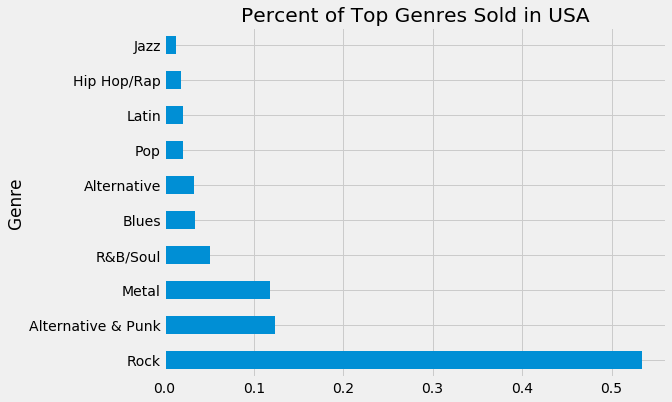

In [17]:
plt.style.use('fivethirtyeight')
genre_sales_usa.iloc[:10].plot.barh(x='name', y='percent_tracks_sold', figsize=(8,6), legend=False) # Only plots the top 10 results
plt.title('Percent of Top Genres Sold in USA')
plt.ylabel('Genre')
plt.show()

The plot shows the tracks sold in the USA by genre. Rock is by far the most popular genre, accounting for more than 50% of all USA track sales. Given these results, the store's first three picks should be:
1. Red Tone (Punk)
2. Slim Jim Bites (Blues)
3. Meteor and the Girls (Pop)

It should be noted, though, that Pop is only ahead of Hip-Hop by a slight margin so Meteor and the Girls could be replaced with Regal with a minimal effect expected. We also observe that, regardless of whether we go with the Pop or Hip Hop album, the three chosen genres only account for less than 18% of USA sales. By comparison, this is less than half of the percent of Rock sales.

### Analyzing Employee Sales Performance

First-time customers are assigned to a sales suport agent who assist with the purchase. The store would like to see how each of the sales support agents are performing relative to each other.

Again, we'll query the store's database to find the answer to this question, this time looking at employee data along with sales records.

In [29]:
q = '''
        SELECT e.employee_id,
        e.first_name|| ' ' ||e.last_name AS sales_rep_name,
        e.hire_date,
        e.state,
        COUNT(DISTINCT c.customer_id) AS no_of_customers,
        SUM(i.total) AS total_sales,
        SUM(i.total) / COUNT(DISTINCT c.customer_id) AS sales_per_customer
        FROM employee e
        LEFT JOIN customer c ON e.employee_id = c.support_rep_id
        LEFT JOIN invoice i ON c.customer_id = I.customer_id
        WHERE e.title = 'Sales Support Agent'
        GROUP BY 1, 2, 3, 4
        ORDER BY 6 DESC
    '''
sales_by_agent = run_query(q)
sales_by_agent

,employee_id,sales_rep_name,hire_date,state,no_of_customers,total_sales,sales_per_customer
0,3,Jane Peacock,2017-04-01 00:00:00,AB,21,1731.51,82.452857
1,4,Margaret Park,2017-05-03 00:00:00,AB,20,1584.00,79.200000
2,5,Steve Johnson,2017-10-17 00:00:00,AB,18,1393.92,77.440000


We retrieved sales and customer information for each employee with the job title "Sales Support Agent". We also pulled additional information (hire date and location) that may give context to their sales performance.

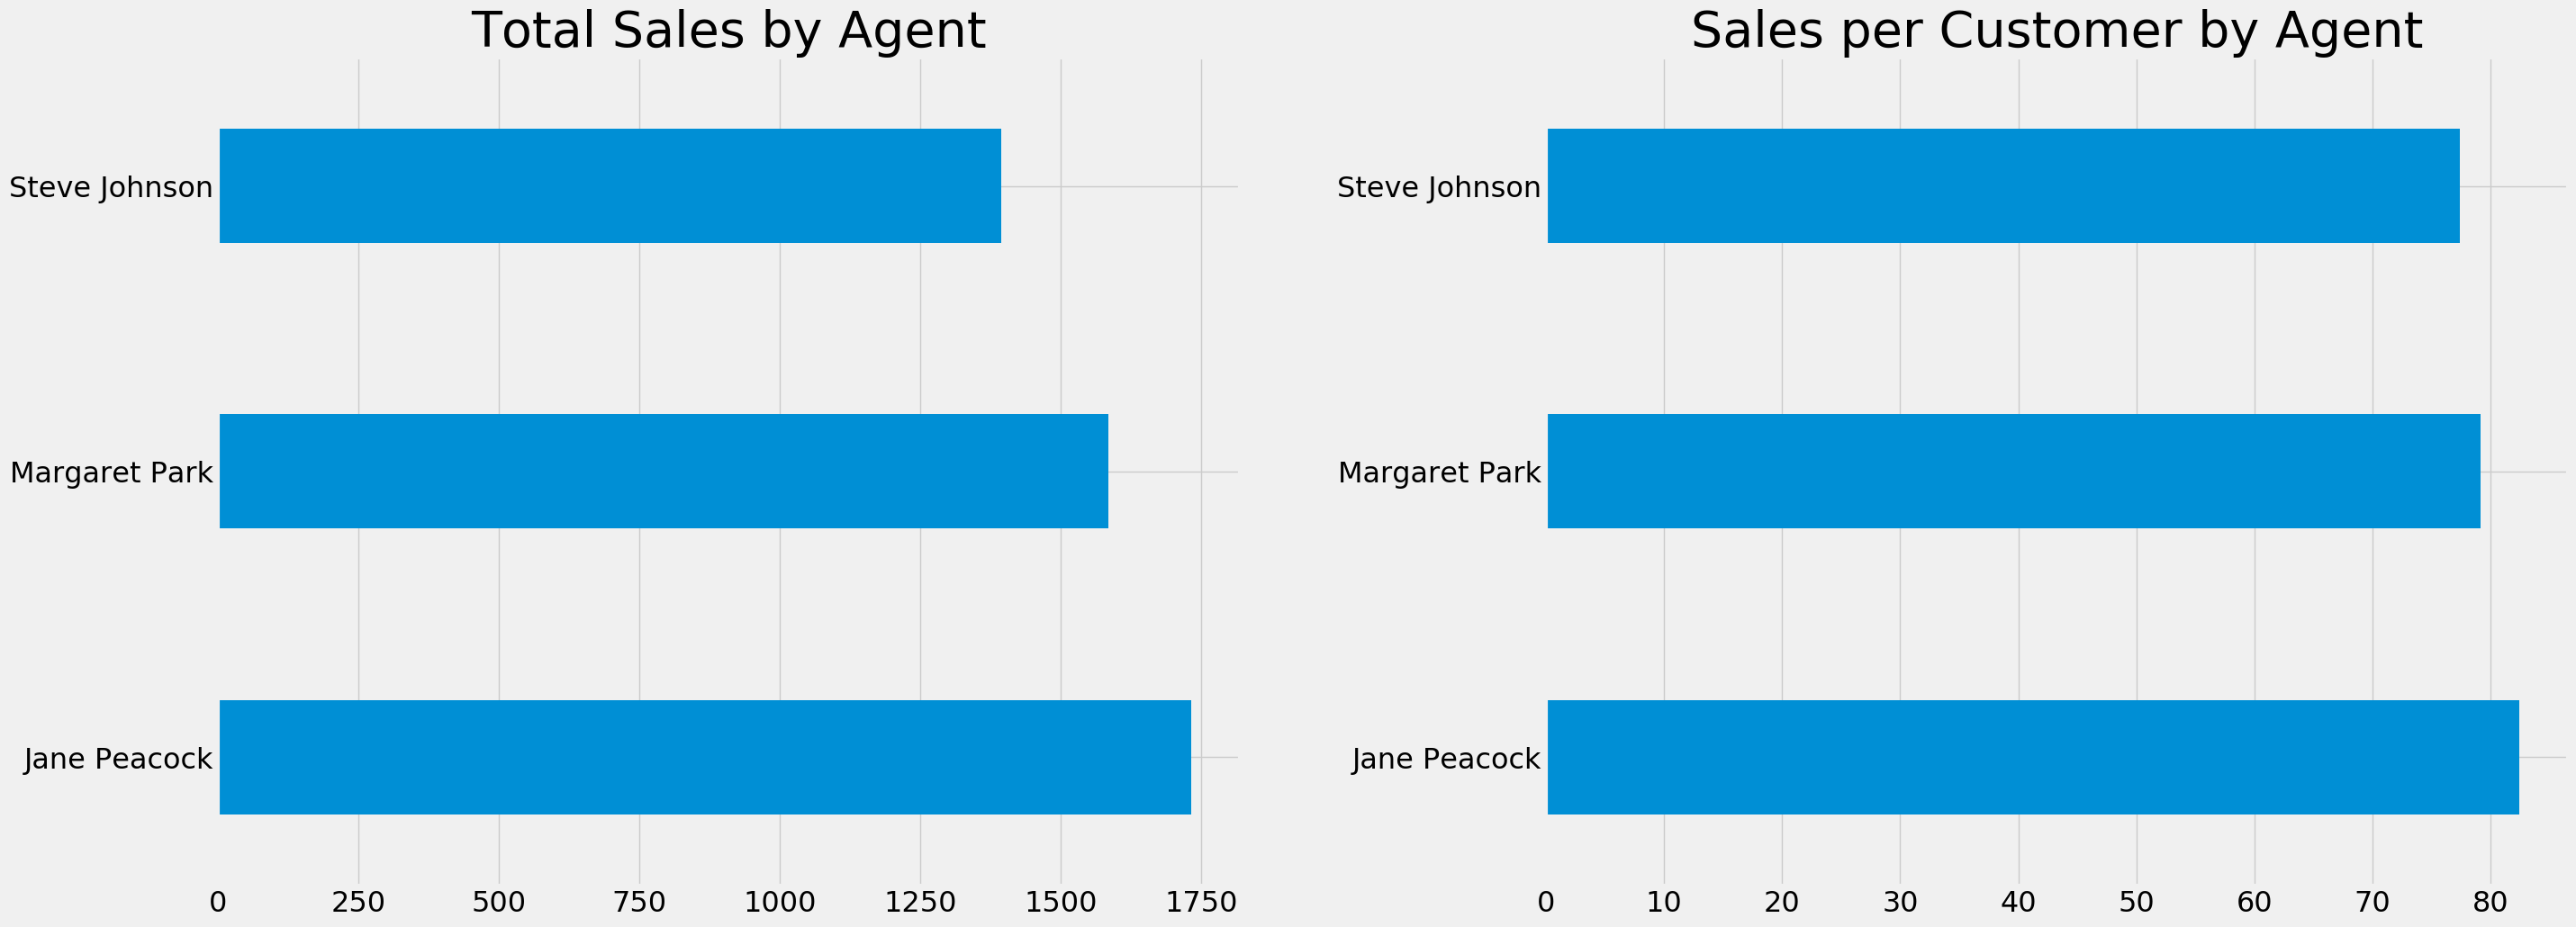

In [277]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(30,25))

#left-hand plot
ax1 = fig.add_subplot(221)
sales_by_agent.plot.barh(x='sales_rep_name', y='total_sales', align='center',legend=False, title='Total Sales by Agent',ax=ax1, fontsize=23, width=.4)
ax1.set_title(ax1.get_title(),fontsize=40)
ax1.set_ylabel('')

# right-hand plot
ax2 = fig.add_subplot(222)
sales_by_agent.plot.barh(x='sales_rep_name', y='sales_per_customer', align='center',legend=False, title='Sales per Customer by Agent',ax=ax2, fontsize=23, width=.4)
ax2.set_title(ax2.get_title(),fontsize=40)
ax2.set_ylabel('')

plt.subplots_adjust(wspace=.3) #to avoid graphs being too close together and "over-crowded"
plt.show()

Based on the above, we observe that Jane Peacock is the best performing agent sales-wise, with about 24% more total sales than Steve Johnson, who has the least amount of total sales. When we factor in start dates, however, we can see that that the total number of sales seem to correspond to how long the agent has been working with the company i.e. Jane Peacock was hired six months before Steve Johnson. This would be expected, since the more time an agent has been employed means the more time to make sales.

To make our performance assessment more accurate, we normalize each agents total sales by number of customers assigned. We find that Jane is still the highest performer but only by a difference of 6.6% from the lowest performer, John.

It's possible that agents improve the longer they are in the job, which could explain why Jane is slightly outpeforming her peers in Sales per Customer.

### Analyzing Sales by Country

The store services customers in several countries, and we've been tasked with calculating some sales statistics by country:

- Total number of customers
- Total value of sales
- Average order value
- Average value of sales per customer

The company's marketing team is also creating some new marketing campaigns and is interested in learning if there's any markets with the potential for growth based on our findings.

For this analysis, we are instructed to use the country field in the `customer` table instead of the billing_country field in the `invoice` table.

First we begin by summarizing the sales stats for each country by querying the store's database. Once again, we'll use a `WITH` clause to aggregate the data by country in a subquery, from which we then calculate the last aggregate value we need (average value of sales per customer)

In [62]:
q = '''WITH countries_grouped AS (
            SELECT c.country,
            AVG(i.total) AS avg_order_value,
            COUNT(DISTINCT c.customer_id) AS no_of_customers,
            SUM(i.total) AS total_sales
            FROM customer c
            LEFT JOIN invoice i ON c.customer_id = i.customer_id
            GROUP BY 1)
        SELECT cg.country,
        SUM(cg.no_of_customers) AS no_of_customers,
        SUM(cg.total_sales) AS total_sales,
        SUM(cg.total_sales) / SUM(cg.no_of_customers) AS avg_sales_per_customer,
        AVG(cg.avg_order_value) AS avg_order_value
        FROM countries_grouped cg
        GROUP BY 1
        ORDER BY 1'''
sales_by_country = run_query(q)
sales_by_country

,country,no_of_customers,total_sales,avg_sales_per_customer,avg_order_value
0,Argentina,1,39.60,39.600000,7.920000
1,Australia,1,81.18,81.180000,8.118000
2,Austria,1,69.30,69.300000,7.700000
3,Belgium,1,60.39,60.390000,8.627143
4,Brazil,5,427.68,85.536000,7.011148
5,Canada,8,535.59,66.948750,7.047237
6,Chile,1,97.02,97.020000,7.463077
7,Czech Republic,2,273.24,136.620000,9.108000
8,Denmark,1,37.62,37.620000,3.762000
9,Finland,1,79.20,79.200000,7.200000


From our query results, we observe the store has customers in 23 countries, but several of them only contain one customer. To streamline the results and avoid reporting values for countries based on a single customer, we combine countries with a single customer into one category, "Other".

To accomplish this, we add a conditional field in the subquery that categorizes a country as "Other" if it only has one customer. We also add a second conditional field, a boolean based on whether the first conditional field is equal to "Other" or not. This allows us to force the "Other" record to the bottom of the results, regardless of the sorting used for the rest of the results.

In [67]:
q = '''WITH countries_grouped AS (
            SELECT c.country AS original_country,
            CASE WHEN COUNT(DISTINCT c.customer_id) = 1 THEN 'Other' ELSE  c.country END AS country,
            COUNT(DISTINCT c.customer_id) AS no_of_customers,
            AVG(i.total) AS avg_order_value,
            SUM(i.total) AS total_sales,
            CASE WHEN COUNT(DISTINCT c.customer_id) = 1 THEN 1 ELSE 0 END AS sort_col
            FROM customer c
            LEFT JOIN invoice i ON c.customer_id = i.customer_id
            GROUP BY 1)
        SELECT cg.country,
        SUM(cg.no_of_customers) AS no_of_customers,
        SUM(cg.total_sales) AS total_sales,
        SUM(cg.total_sales) / SUM(cg.no_of_customers) AS avg_sales_per_customer,
        AVG(cg.avg_order_value) AS avg_order_value
        FROM countries_grouped cg
        GROUP BY 1
        ORDER BY cg.sort_col ASC, 2 DESC'''
sales_by_country = run_query(q)
sales_by_country

,country,no_of_customers,total_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Czech Republic,2,273.24,136.620000,9.108000
7,India,2,183.15,91.575000,8.721429
8,Portugal,2,185.13,92.565000,6.383793
9,Other,15,1094.94,72.996000,7.445071


We observe that the USA is the country with the highest amount of total sales, as well as the most number of customers, however, the combined countries that make up the "Other" category have a slightly higher amount of customers and total sales than even the USA. Another interesting insight is that the Czech Reublic has the highest average order value and highest average value of sales per customer, despite havingone of the lowest amounts of customers. From this, we can tell that on average, the customers in the Czech Republic have spent a large amount of money per order.

Next we'll summarize our findings for the marketing team with some visualizations.

In [69]:
sales_exc_other = sales_by_country.loc[0:8,:] # exclude the "Other" category since this isn't an actual location marketigng can focus on

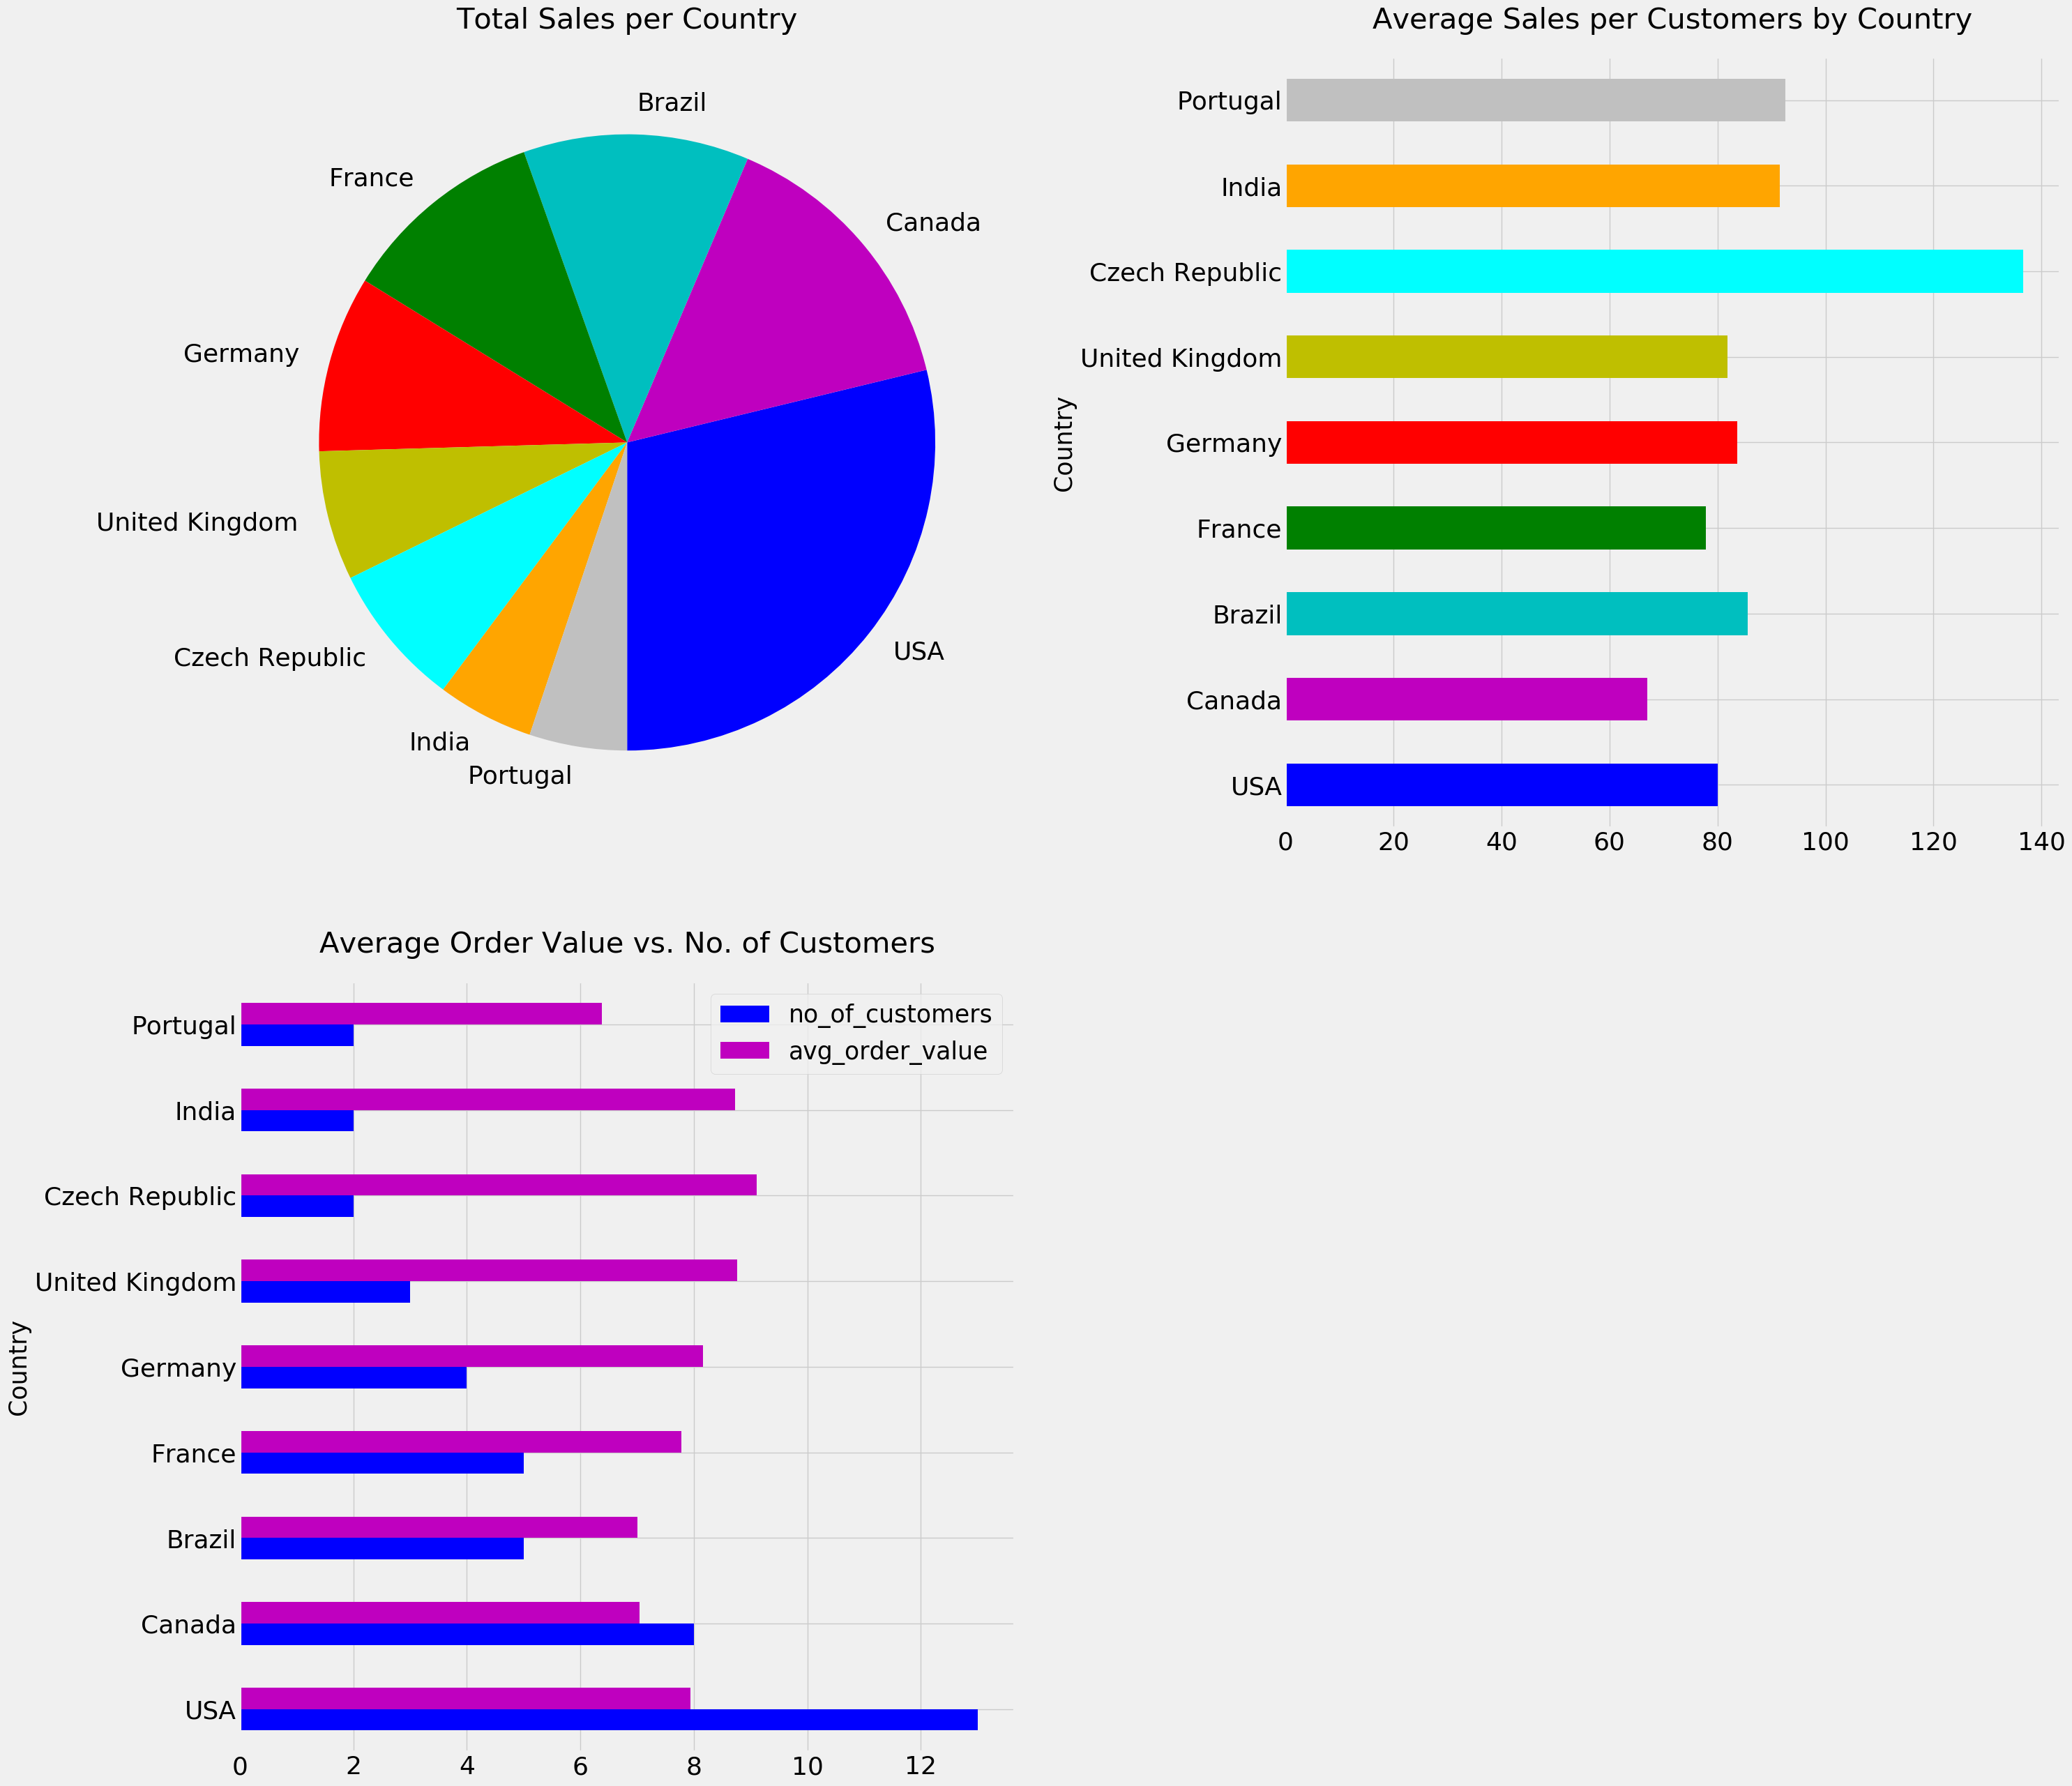

In [278]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(30,30))

#top-left plot
ax1 = fig.add_subplot(221)
sales_exc_other.plot.pie(labels=sales_exc_other['country'], y='total_sales', startangle=-90, legend=None, colors=['b','m','c','g','r','y','aqua','orange','silver'], title='Total Sales per Country',ax=ax1,fontsize=26)
ax1.set_title(ax1.get_title(),fontsize=30, y= 1.03)
ax1.set_ylabel('')


#top-right plot
ax2 = fig.add_subplot(222)
sales_exc_other.plot.barh(x='country',y='avg_sales_per_customer', align='center', color=['b','m','c','g','r','y','aqua','orange','silver'],legend=None,title='Average Sales per Customers by Country',ax=ax2,fontsize=26)
ax2.set_title(ax2.get_title(),fontsize=30, y= 1.03)
ax2.set_ylabel('Country', fontsize=25)


#bottom-left plot
ax3 = fig.add_subplot(223)
sales_exc_other.plot.barh(x='country', y=['no_of_customers','avg_order_value'], color= ['b', 'm'], align='center',title='Average Order Value vs. No. of Customers',ax=ax3,fontsize=26)
ax3.set_title(ax3.get_title(),fontsize=30, y= 1.03)
ax3.legend(fontsize=25)
ax3.set_ylabel('Country', fontsize=25)

plt.subplots_adjust(wspace=.35,hspace=.2)
plt.show()

Based on total sales, we see that the USA dominates, with over 25% of all total sales. This is followed Canada, France, and Brazil, who together have about a third of total sales. The number of customers in these countries are on the high end of the range, but interestingly enough, the value of average sales by customer in these countries are in the lower end of the range. Based on this, these countries seem to pretty stable and are already perforing well sales-wise.

We instead focus our attention on the countries with a lower percentage of total sales: United Kingdom, Czech Republic, India, and Portugal. These countries combine to make up about 25% of total sales and only have 3 or less customers each, yet, the UK, Czech Republic and India have the highest average order values. The Czech Republic, India, and Portugal also have the highest amount average sales by customer. So while these countries don't have the most customers, the customer they do have spent a relative high amount on the store.

Our recommendation is that the marketing team focus their marketing campaigns on the Czech Republic and India as these markets have the potential for growth and generating higher sales with more customers. The UK and Portugal are also good candidates, and a case can be argued for each if a third choice was needed.

It's important to keep in mind that the samples are small, with each country having a small amount of customers. While we expect the Cezch Republic and India have the potential for growth, our confidence in the analysis isn't very high given the small sample. Marketing campaigns should start small, ideally as experiments to further gain more data and insight about sales in these countries.

### Album Sales vs. Track Sales


The store is setup in a way that allows customer to make purchases in one of the two ways:

- purchase a whole album
- purchase a collection of one or more individual tracks.

Customers cannot purchase a whole album and then add individual tracks to that same purchase (unless they do that by choosing each track in the album manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

The management team is considering ways to cut costs. One suggestion is to change their purchasing strategy. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

To determine if this is the right move, we are asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

For this analysis, we need to be aware of two edge cases flagged by the team:

- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

We are provided with the following information by the management team:
- The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case.

For the first edge case, since the goal of the management team is to increase revenue and album cost depends on number of tracks, we feel confident making the assumption that albums with one or two tracks have a minimal impact on revenue.

Given this, we will define an album purchase to be when a customer purchased all the tracks within one album in a single order, with no other tracks added to the order.

This analysis will rely on a number of subqueries, including one within a `WITH` clause. This subquery will add a field to the `invoice_line` table, letting know what album each `invoice_line` record corresponds to. This allows us to check if each track purchased in an order was purchased along with the rest of the tracks from the same album (an album purchase) or not.

From there we can aggregate our results by invoice, using the ordering to only count album purchases as we defined.

Then we add a final query to summarize our findings.

In [276]:
q = '''
WITH invoice_album AS (
    SELECT il.*, t.album_id
    FROM invoice_line il
    LEFT JOIN track t ON il.track_id = t.track_id
    )

SELECT album_purchase, 
COUNT(DISTINCT invoice_id) AS no_of_invoices,
COUNT(DISTINCT invoice_id) / CAST((SELECT COUNT(*) FROM invoice) AS FLOAT) *100 AS percent_of_invoices
FROM
    (
    SELECT invoice_id,album_purchase
    FROM
        (
        SELECT
        invoice_id,
        CASE WHEN (
            SELECT track_id
            FROM track
            WHERE album_id = ia.album_id
            EXCEPT
            SELECT track_id
            FROM invoice_album
            WHERE invoice_id = ia.invoice_id
            ) IS NULL 
        THEN 'Yes' ELSE "No" END AS album_purchase
        FROM invoice_album ia
        ORDER By 1 asc, 2 asc
        )
    GROUP BY 1
    )
GROUP BY 1
'''

run_query(q)

,album_purchase,no_of_invoices,percent_of_invoices
0,No,500,81.433225
1,Yes,114,18.566775


According to our results, most purchases are individual tracks as opposed to album purchases however, album purchases still make up about 20% of orders. This is a significant amount and changing the purchasing strategy to not buying whole albums will have an adverse effect on those orders.

Our recommendation is then that the management team should not change the purchasing strategy without a cost analysis that can confirm that the savings from the change will outweigh the loss of album orders.